第一题

In [1]:
from lxml.html import parse
from urllib2 import urlopen
from os.path import getsize
from math import log
from pandas import Series, DataFrame
import pandas as pd
import urllib 
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.tsa.stattools import q_stat, acf, pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import datetime
%matplotlib inline

In [2]:
def get_sina_stock(stockid,start="1990-12-19",end=pd.datetime.now(),isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts] # .strip()去掉\r\t\n之类的字符    
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] # 回避中文处理
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print "download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3)
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)    

In [1]:
data=get_sina_stock("000001","1991-1-1","2014-12-31",isstock=False)
data_month_high=data['high'].resample("M",how="mean")
data_month_low=data['low'].resample("M",how="mean")
data_month_high_log=data_month_high.map(log)
data_month_low_log=data_month_low.map(log)
data_month_bodong=data_month_high_log-data_month_low_log
data_month_bodong

NameError: name 'get_sina_stock' is not defined

In [4]:
def autocoef(data,k):
    meanw=np.mean(data)
    n=len(data)    
    return np.nansum((data[:(n-k)]-meanw)*(data[k:]-meanw))/np.nansum((data-meanw)**2)
def qtest(data,m,plot):
    q=np.zeros(m)
    l=[(autocoef(data,i+1))**2 for i in range(m)]
    for j in range(m):
        q[j]=sum(l[:j+1])*len(data)
        print(q[j])
    if plot==1:
        plt.figure(figsize=(6,5))
        plt.plot(range(1,m+1),q[:],"b*",[1,m],stats.chi2.ppf(0.95,[1,m]),"r--")

In [5]:
log(len(data_month_bodong))

5.662960480135946

283.463128679
563.372684874
839.680599623
1112.49484359
1382.26701977
1649.2048779


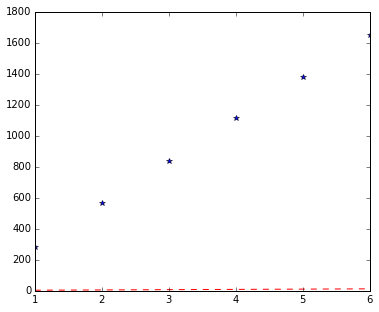

In [6]:
qtest(data_month_bodong,6,1)

由上图可以看出，各自由度的Q统计量的值远大于卡方分布的95%的置信水平线，所以拒绝白噪声检验

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001F942E48>], dtype=object)

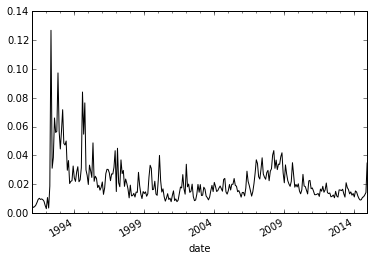

In [7]:
data_month_bodong.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001F8C1780>], dtype=object)

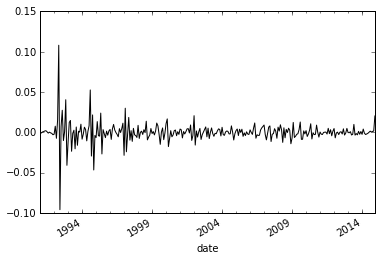

In [8]:
data_month_bodong=data_month_bodong-data_month_bodong.shift(1)
data_month_bodong.plot(subplots=True)

In [9]:
data_month_bodong=data_month_bodong.dropna()

In [10]:
adfuller(data_month_bodong)

(-8.1710592666040203,
 8.6204499674905083e-13,
 15L,
 271L,
 {'1%': -3.4547128138328875,
  '10%': -2.5724850011573914,
  '5%': -2.8722649771800155},
 -1805.9937269009861)

count    287.000000
mean       0.000105
std        0.012667
min       -0.095757
25%       -0.003221
50%        0.000012
75%        0.003761
max        0.108143
dtype: float64


array([  1.00000000e+00,  -3.98398557e-01,  -9.65313780e-02,
         1.06862209e-01,  -4.76836681e-02,  -1.04641761e-01,
         1.57391203e-01,   9.12940281e-04,  -1.18525512e-01,
         5.46630372e-02,   6.34744744e-02,  -7.53351666e-02,
        -2.84377234e-02,   3.51466821e-02,  -3.24192657e-02,
        -1.01000551e-02])

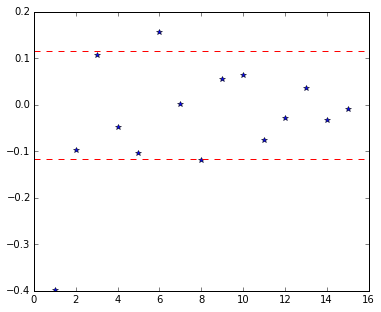

In [11]:
print data_month_bodong.describe()
acf(data_month_bodong,nlags=15)
k=15
autoco=acf(data_month_bodong,nlags=k)
n=len(data_month_bodong)
plt.figure(figsize=(6,5))
plt.plot(range(1,k+1),autoco[1:],"b*",[0,k+1],[1.96/np.sqrt(n)]*2,"r--",[0,k+1],[-1.96/np.sqrt(n)]*2,"r--")
acf(data_month_bodong,nlags=15)

由图可知MA模型的阶应该取8

In [12]:
print(1.96/np.sqrt(len(data_month_bodong)))
pacf(data_month_bodong,10)

0.115695141876


array([ 1.        , -0.39979156, -0.30594176, -0.08545339, -0.07591949,
       -0.18000932,  0.01770382,  0.06744801, -0.05291108, -0.03858413,
        0.05268082])

由此可知AR模型的阶应该取5

In [13]:
mean=data_month_bodong.mean()
data_month_bodong=data_month_bodong-mean
res = sm.tsa.arma_order_select_ic(data_month_bodong, ic=['aic', 'bic'], trend='nc')
print res.aic_min_order,res.bic_min_order
print res.aic
print res.bic

(0, 1) (0, 1)
             0            1            2
0          NaN -1773.490711 -1772.232049
1 -1740.133796 -1772.118032 -1771.097936
2 -1766.490402 -1770.796790 -1769.491750
3 -1766.788129 -1773.332665 -1771.604659
4 -1766.563832 -1771.475973 -1769.648888
             0            1            2
0          NaN -1766.171747 -1761.253602
1 -1732.814831 -1761.139585 -1756.460007
2 -1755.511956 -1756.158861 -1751.194338
3 -1752.150200 -1755.035254 -1749.647765
4 -1748.266421 -1749.519080 -1744.032513


C:\Users\xiayingfan\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


下面用ARIMA(0,1,1)模型进行拟合

In [14]:
arma_mod1 = sm.tsa.ARIMA(data_month_bodong,order=(0,1,1))
arma_res = arma_mod1.fit(trend='nc')
arma_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            Log-Likelihood:      840.83    
Dependent Variable: D.y              Scale:               1.0000    
Date:               2015-12-29 23:04 Method:              css-mle   
No. Observations:   286              Sample:              03-31-1991
Df Model:           1                                     12-31-2014
Df Residuals:       285              S.D. of innovations: 0.013     
AIC:                -1677.6519       HQIC:                -1674.721 
BIC:                -1670.3399                                      
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
ma.L1.D.y      -1.0000    0.0087  -114.4464  0.0000  -1.0171  -0.9829
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
MA.1            1.0000             0.0000           1.0000             0.0000
====================================================================

"""

拟合出来的模型为：$${r_t} = {r_{t - 1}} + {\varepsilon _t} + {\varepsilon _{t - 1}}$$


残差的方差为

In [15]:
arma_res.resid.std()

0.012951325666885392

下面加入月天数统计

In [16]:
a=pd.date_range('1/1/1991','31/12/2014',freq='M')
index=list(a)
num=list(a)
for i in range(len(index)):
    x=list(str(index[i]))
    x=x[:7]
    index[i]=''.join(x)
for i in range(len(index)):
    num[i]=len(data[index[i]])
num=num[:len(num)-1]
num

[22,
 18,
 21,
 22,
 22,
 20,
 23,
 22,
 21,
 21,
 21,
 22,
 22,
 17,
 22,
 22,
 20,
 22,
 23,
 21,
 22,
 20,
 21,
 23,
 18,
 20,
 23,
 22,
 21,
 22,
 22,
 22,
 22,
 20,
 22,
 23,
 21,
 15,
 23,
 21,
 21,
 22,
 21,
 23,
 22,
 19,
 22,
 22,
 19,
 17,
 23,
 20,
 22,
 22,
 21,
 23,
 21,
 20,
 22,
 21,
 22,
 12,
 20,
 22,
 22,
 20,
 23,
 22,
 20,
 21,
 21,
 22,
 22,
 10,
 21,
 22,
 20,
 20,
 22,
 21,
 22,
 20,
 20,
 23,
 15,
 15,
 22,
 22,
 20,
 22,
 23,
 21,
 22,
 20,
 21,
 23,
 20,
 7,
 23,
 22,
 20,
 22,
 22,
 22,
 22,
 16,
 22,
 21,
 19,
 12,
 23,
 20,
 18,
 22,
 21,
 23,
 21,
 17,
 22,
 21,
 14,
 18,
 22,
 21,
 18,
 21,
 22,
 23,
 20,
 18,
 22,
 21,
 20,
 10,
 21,
 22,
 18,
 20,
 23,
 22,
 20,
 18,
 21,
 22,
 20,
 15,
 21,
 22,
 15,
 21,
 23,
 21,
 22,
 18,
 20,
 23,
 13,
 20,
 23,
 22,
 16,
 22,
 22,
 22,
 22,
 16,
 22,
 23,
 20,
 13,
 23,
 21,
 17,
 22,
 21,
 23,
 22,
 16,
 22,
 22,
 16,
 17,
 23,
 20,
 18,
 22,
 21,
 23,
 21,
 17,
 22,
 21,
 20,
 15,
 22,
 21,
 18,
 21,
 22,
 23,
 

In [17]:
X = sm.add_constant(num, prepend=False)
results2 = sm.OLS(data_month_bodong, X).fit()
results2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.740
Date:                Tue, 29 Dec 2015   Prob (F-statistic):              0.188
Time:                        23:04:33   Log-Likelihood:                 847.98
No. Observations:                 287   AIC:                            -1692.
Df Residuals:                     285   BIC:                            -1685.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0004      0.000      1.319      0.188        -0.000     0.001
const         -0.0078      0.006     -1.309      0.192        -0.020     0.004
==============================================================================
Omnibus:                      122.244   Durbin-Watson:                   2.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10946.447
Skew:                           0.680   Prob(JB):                         0.00
Kurtosis:                      33.225   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([  5.48144217e-04,   1.09657003e-03,   1.23035732e-03,
          1.57069962e-03,   2.17637088e-03,   2.37162318e-03,
          3.47061568e-03,   3.50413366e-03,   3.73192778e-03,
          4.35617790e-03,   7.44887305e-03,   1.01995469e-02,
          2.51046020e-02,   3.63183818e-02,   1.00626987e-01,
          3.63223065e+00,   6.44669702e+00,   6.46026252e+00,
          6.67637780e+00,   6.71005516e+00,   6.71005591e+00,
          7.22619521e+00,   7.75702375e+00,   7.81138049e+00,
          7.86643874e+00,   7.93706927e+00,   8.12802452e+00,
          8.12914718e+00,   8.13103564e+00,   8.27386102e+00,
          8.28558652e+00,   8.37595297e+00,   8.37616962e+00,
          8.37623244e+00,   8.40591145e+00,   8.43553763e+00,
          8.43787687e+00,   8.46188302e+00,   8.46403255e+00,
          8.50306555e+00,   8.50339640e+00,   8.52282799e+00,
          9.45426011e+00,   9.76961256e+00,   9.92090490e+00,
          1.06530840e+01,   1.06600435e+01,   1.06774751e+01,
        

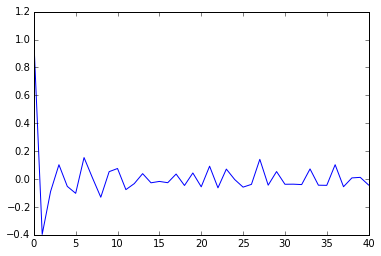

In [18]:
plt.plot(acf(results2.resid.values) )
q_stat(results2.resid,len(results2.resid))

0.11805626722


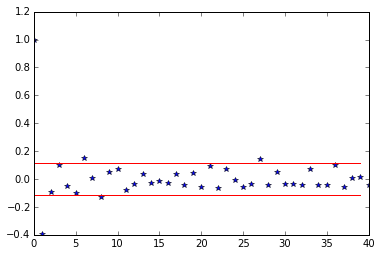

In [19]:
resi=results2.resid
resi=resi.dropna()
plt.plot(acf(resi),"*",[2/np.sqrt(len(resi))]*40,"r-",[-2/np.sqrt(len(resi))]*40,"r-")
print 2/np.sqrt(len(resi))

In [20]:
es = sm.tsa.arma_order_select_ic(resi, ic=['aic', 'bic'], trend='nc')
print es.aic_min_order,es.bic_min_order
print es.aic
print es.bic

(3, 1) (0, 1)
             0            1            2
0          NaN -1773.327370 -1772.262477
1 -1741.472221 -1772.158216 -1770.976848
2 -1766.040775 -1770.455213 -1769.132000
3 -1766.075145 -1773.421933 -1771.501770
4 -1765.998218 -1771.467670 -1767.490338
             0            1            2
0          NaN -1766.008406 -1761.284031
1 -1734.153257 -1761.179769 -1756.338919
2 -1755.062329 -1755.817285 -1750.834589
3 -1751.437216 -1755.124521 -1749.544877
4 -1747.700807 -1749.510777 -1741.873962


下面按ARIMA(3,1,1)模型拟合

In [21]:
arma_mod1 = sm.tsa.ARIMA(data_month_bodong,order=(3,1,1),exog=X)
arma_res = arma_mod1.fit(trend='nc')
arma_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            Log-Likelihood:      861.71    
Dependent Variable: D.y              Scale:               1.0000    
Date:               2015-12-29 23:11 Method:              css-mle   
No. Observations:   286              Sample:              03-31-1991
Df Model:           6                                     12-31-2014
Df Residuals:       280              S.D. of innovations: 0.012     
AIC:                -1709.4115       HQIC:                -1699.154 
BIC:                -1683.8196                                      
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
x1          -0.0000     0.0001    -0.3002   0.7642   -0.0003    0.0002
const        0.0009     0.0029     0.3019   0.7629   -0.0048    0.0065
ar.L1.D.y   -0.7101     0.0343   -20.7094   0.0000   -0.7773   -0.6429
ar.L2.D.y   -0.4846     0.0392   -12.3505   0.0000   -0.5615   -0.4077
ar.L3.D.y   -0.1638     0.0476    -3.4445   0.0007   -0.2570   -0.0706
ma.L1.D.y   -0.7769        nan        nan      nan       nan       nan
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -0.3593            -1.6114           1.6510            -0.2849
AR.2           -0.3593             1.6114           1.6510             0.2849
AR.3           -2.2396            -0.0000           2.2396            -0.5000
MA.1            1.2872             0.0000           1.2872             0.0000
====================================================================

"""

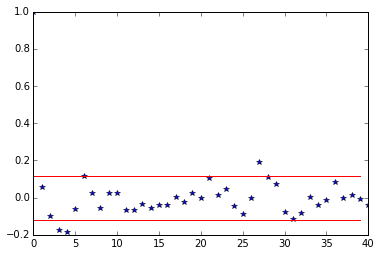

In [22]:
plt.plot(acf(arma_res.resid),"*",[2/np.sqrt(len(resi))]*40,"r-",[-2/np.sqrt(len(resi))]*40,"r-")

可以看到x1前系数很小，所以相关性不显著。

第二题

d应该取2，第一个acf图说明这个时间序列有线性趋势项，第二个acf图说明一阶差分后的序列是一个白噪声序列，第三个acf图说明二阶差分后的时间序列可以用6阶MA模型进行拟合。

第三题

In [23]:
y=[0,0,0,0]
e=[0,0]
sigma=[0,0]
y[0]=120.1
y[1]=118.3
e[0]=-2.3
e[1]=2.6
y[2]=103+0.2*y[1]+0.4*e[1]-0.25*e[0]
y[3]=103+0.2*y[2]-0.25*e[1]
sigma[0]=1
sigma[1]=1+0.2**2+0.25**2
print(y[2],y[3])
print([[y[2]-1.96*sigma[0],y[2]+1.96*sigma[0]],[y[3]-1.96*sigma[1],y[3]+1.96*sigma[1]]])

(128.275, 128.005)
[[126.31500000000001, 130.235], [125.8441, 130.1659]]
